In [35]:
import numpy as np

import dask
import dask.array as da
from dask.delayed import Delayed,delayed

In [38]:
import warnings

warnings.simplefilter("ignore")


def next_pow_two(n):
    """Returns the next power of two greater than or equal to `n`"""
    i = 1
    while i < n:
        i = i << 1
    return i


def calc_acf(array: np.ndarray, norm: bool = True):

    n = next_pow_two(len(array))
    f = np.fft.fft(array - np.mean(array), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(array)].real
    if norm:
        acf /= acf[0]
    return acf

def auto_window(taus: np.ndarray, c: int):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


def estimate_iat(acf: np.ndarray, c: int = 5) -> float:
    iats = 2.0 * np.cumsum(acf) - 1.0
    window = auto_window(iats, c)
    iat_estimation = iats[window]
    return iat_estimation


In [229]:
class CalcMean:

    def __init__(self, strategy):
        self._strategy = strategy

    def compute(self, array: np.ndarray | da.Array) -> np.ndarray | da.Array:

        match array:
            case np.ndarray():
                result = np.apply_along_axis(self._strategy.compute, 0, array).mean()
            case da.Array() | Delayed():
                result = da.apply_along_axis(self._strategy.compute, 0, array).mean()
            case _:
                raise TypeError(f"input type {type(array)} is invalid.")

        return result

class FFT:

    def compute(self, array: np.ndarray | da.Array) -> np.ndarray | da.Array:
        match array:
            case np.ndarray():
                result = self._calc_iat(array)
            case da.Array() | Delayed():
                result = da.map_blocks(self._calc_iat, array)
            case _:
                raise TypeError(f"input type {type(array)} is invalid.")
        return result

    @staticmethod
    def _calc_iat(array: np.ndarray) -> np.ndarray:
        """calculate integrated auto-correlation time
        :param array: input array
        :return: iat array
        """
        acf = calc_acf(array)
        result = estimate_iat(acf)
        return result


In [230]:
inst = CalcMean(FFT())

In [231]:
arr = np.random.rand(1000, 10)
arr = da.from_array(arr)

In [232]:
res = inst.compute(arr)
res.compute()

1.0123797299091513

In [233]:
res
#res.visualize()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

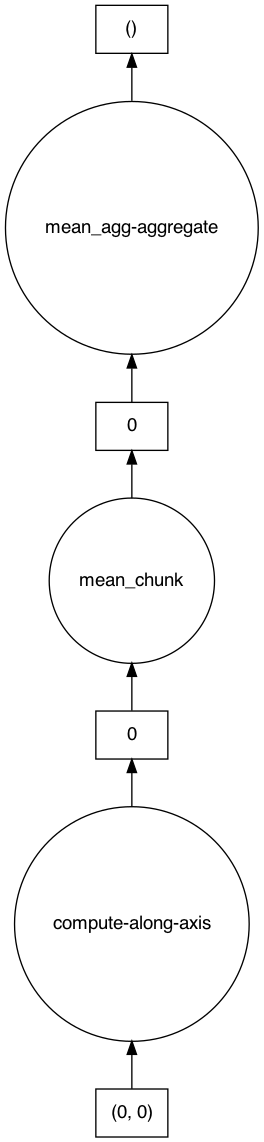

In [234]:
res.visualize()

In [236]:
inst = CalcMean(FFT())
arr = np.random.rand(1000, 10)
res = inst.compute(arr)
res

0.9478143185614553

In [237]:
arr = np.random.rand(1000)
res = FFT().compute(arr)
print(res)

1.2773222370859116


In [238]:
arr = da.from_array(np.random.rand(1000))
res = FFT().compute(arr)
res.compute()

1.0905966684792512

In [239]:
res

dask.array<_calc_iat, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

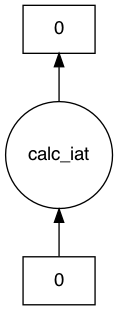

In [240]:
res.visualize()

<module 'dask' from '/Users/dai/miniforge3/envs/bayesian_interface/lib/python3.10/site-packages/dask/__init__.py'>

In [255]:
res = da.zeros(10,)[None]#.mean()
res.compute().shape

(1, 10)

In [260]:
sum([True, True])

2